In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from pathlib import Path

import boa

import levitas as lv

In [2]:
cn_str = 
token = 
api = lv.TS(token, cn_str)

In [3]:
rename_map = {99837: 'Original'}

prices_df = api.prices(symbol_ids=99837, fill_holes=True).rename(columns = rename_map).dropna()

prices_df.columns.name = 'Index'
prices_df.index.name = 'Date'

prices_df = prices_df.rebase()

Text(0, 0.5, '100-base prices')

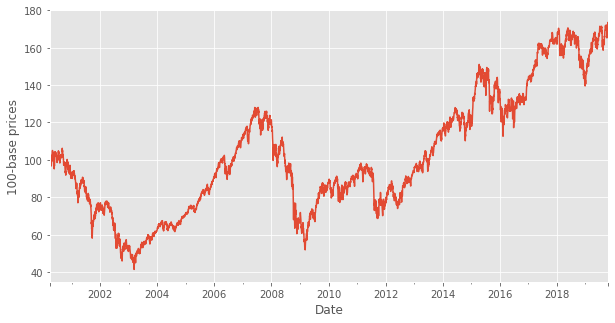

In [4]:
ax = prices_df.plot(legend=False, figsize = (10,5))

ax.set_ylabel('100-base prices')
ax.grid(True)
plt.savefig('./figures/only_original.png', transparent = True, bbox_inches = 'tight', dpi = 500)

In [5]:
n_days = prices_df.shape[0]
a_T = prices_df.total_return(factor=1/(n_days-1), log=False).values[0]
a_T

0.00010708485669641554

In [6]:
# Build the risk free price series
prices_df['Risk-free'] = a_T

prices_df.loc[prices_df.index[0], 'Risk-free'] = 0.0
prices_df['Risk-free'] = prices_df['Risk-free'].add(1.0).cumprod().mul(100)

Text(0, 0.5, '100-base prices')

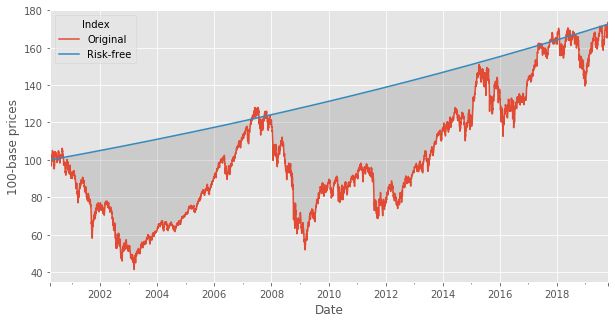

In [7]:
ax = prices_df.plot(figsize = (10,5))

ax.set_ylabel('100-base prices')

ax.fill_between(prices_df.index, prices_df['Original'], prices_df['Risk-free'], 
                alpha = 0.25, color = 'grey')
plt.savefig('./figures/original_and_risk_free.png', transparent = True, bbox_inches = 'tight', dpi = 500)

In [8]:
prices_df.tail()

Index,Original,Risk-free
Date,,
2019-10-14,171.659422,172.558847
2019-10-15,173.558874,172.577325
2019-10-16,173.568324,172.595806
2019-10-17,173.237573,172.614288
2019-10-18,172.632773,172.632773


In [9]:
returns_df = prices_df.returns()

In [10]:
def space_curves_arithmetic(eps, returns_df, annualized_ret):
    """
    Linear interpolation between the original returns
    and the annualized series.
    Parameters
    ----------
    eps: float
    returns_df: pd.DataFrame
    annualized_ret: float
    Returns
    -------
    pd.DataFrame
    """
    return returns_df * (1-eps) + eps * annualized_ret

In [49]:
space_curves_df = pd.DataFrame()
space_curves_df['Original']  = returns_df['Original'] 

N = 10

for eps in np.linspace(0.05, 2.0, N):
    eps = np.round(eps, 2)
    space_curves_df[eps] = space_curves_arithmetic(eps, returns_df['Original'], a_T)

space_curves_df['Risk-free'] = a_T
space_curves_df = space_curves_df.r2p()


D:\Users\emillan\envs\ns\lib\site-packages\boa\ts\core.py:83: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  pd_kwargs['index'] = idx.insert(0, idx[0] - 1)


[Text(0, 0.5, '100-base price'),
 Text(0.5, 1.0, 'Space of curves induced over the arithmetic returns')]

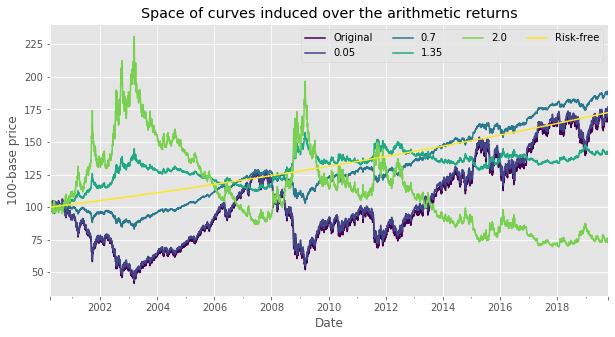

In [23]:
ax = space_curves_df.plot(colormap='viridis', figsize=(10,5))

ax.set(title='Space of curves induced over the arithmetic returns', ylabel='100-base price')
ax.legend(ncol = 4)

# plt.savefig('./figures/arithmetic_returns.png', transparent = True, bbox_inches = 'tight', dpi = 500)

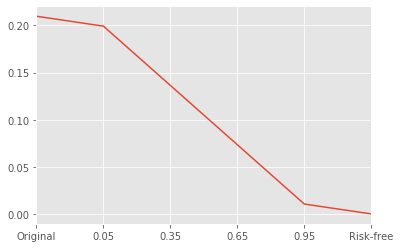

In [13]:
space_curves_df.p2r().volatility().plot()

---

In [24]:
def space_curves_logarithmic(eps, returns_df, annualized_ret):
    """
    Linear interpolation between the original returns
    and the annualized series.
    Parameters
    ----------
    eps: float
    returns_df: pd.DataFrame
    annualized_ret: float
    Returns
    -------
    pd.DataFrame
    """
    # Get logarithmic returns
    _ret_log = returns_df.r2r(to='logarithmic').copy()
    #_ret_log = returns_df.add(1.0).apply(np.log).copy()
    _at_log = np.log(1+annualized_ret)
    
    _ret_interpolation = _ret_log * (1-eps) + eps * _at_log
    
    return _ret_interpolation.r2r(to='arithmetic')

In [51]:
space_curves_log_df = pd.DataFrame()
space_curves_log_df['Original']  = returns_df['Original'] 

for eps in np.linspace(-2.95, 2.95, N):
    eps = np.round(eps, 2)
    space_curves_log_df[eps] = space_curves_logarithmic(eps, returns_df['Original'], a_T)

space_curves_log_df['Risk-free'] = a_T
space_curves_log_df = space_curves_log_df.r2p()

[Text(0, 0.5, '100-base price'),
 Text(0.5, 1.0, 'Space of curves induced over the arithmetic returns')]

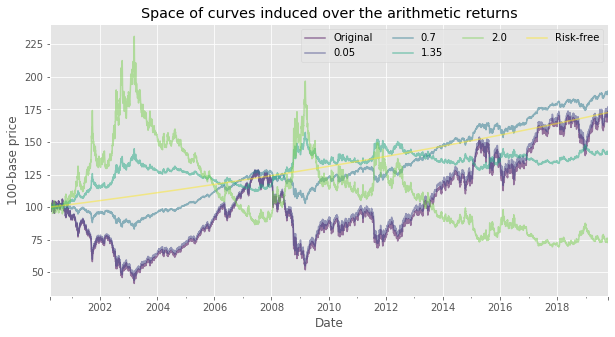

In [32]:
ax = space_curves_df.plot(colormap='viridis', figsize=(10,5), alpha = 0.5)

ax.set(title='Space of curves induced over the arithmetic returns', ylabel='100-base price')
ax.legend(ncol = 4)
# plt.savefig('./figures/arithmetic_returns.png', transparent = True, bbox_inches = 'tight', dpi = 500)

In [52]:
space_curves_log_df.p2c().tail()

,Original,-2.95,-2.29,-1.64,-0.98,-0.33,0.33,0.98,1.64,2.29,2.95,Risk-free
Date,,,,,,,,,,,,
2019-10-14,0.716594,0.690333,0.696174,0.701945,0.707825,0.713636,0.719557,0.725408,0.731370,0.737261,0.743263,0.725588
2019-10-15,0.735589,0.764871,0.758277,0.751807,0.745262,0.738840,0.732343,0.725969,0.719520,0.713193,0.706792,0.725773
2019-10-16,0.735683,0.764693,0.758161,0.751751,0.745267,0.738905,0.732468,0.726152,0.719763,0.713493,0.707150,0.725958
2019-10-17,0.732376,0.750894,0.746734,0.742646,0.738506,0.734438,0.730316,0.726267,0.722166,0.718136,0.714053,0.726143
2019-10-18,0.726328,0.726328,0.726328,0.726328,0.726328,0.726328,0.726328,0.726328,0.726328,0.726328,0.726328,0.726328


In [53]:
from matplotlib import cm

[Text(0.5, 1.0, 'Arithmetic (Transparent) | Logarithmic (Solid)')]

[Text(0, 0.5, '100-base price')]

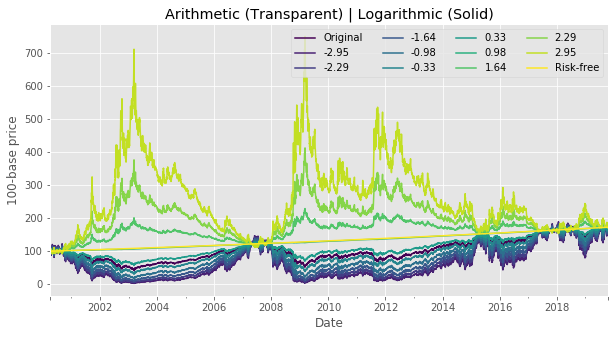

In [57]:
colormap = cm.get_cmap('viridis', lut = len(space_curves_df.columns))

fig, ax = plt.subplots(1,1, figsize = (10,5))

for index, element in enumerate(space_curves_log_df.columns, start = 0):
    
#     space_curves_log_df[element].plot(ax=ax, c = colormap(index), 
#                                   linestyle = '-.', alpha = 0.5, 
#                                   linewidth = 1.0);
    space_curves_log_df[element].plot(ax=ax, c = colormap(index), alpha = 1.0);
    

#ax = space_curves_df.plot(c='red', figsize=(10,5), alpha = 0.5)
#space_curves_log_df.plot(c='Green', ax = ax, alpha = 0.5)

ax.set(title='Arithmetic (Transparent) | Logarithmic (Solid)')
ax.set(ylabel='100-base price')
ax.legend(ncol = 4)
# plt.savefig('./figures/comparison_returns.png', transparent = True, bbox_inches = 'tight', dpi = 500)

In [55]:
volatility_df = pd.DataFrame()

# volatility_df['Interp. over arithmetic rets.'] = space_curves_df.p2r().volatility()
volatility_df['Interp. over logarithmic rets.'] = space_curves_log_df.p2r().volatility()

[Text(0, 0.5, '%'),
 Text(0.5, 0, '$\\varepsilon$'),
 Text(0.5, 1.0, 'Volatility')]

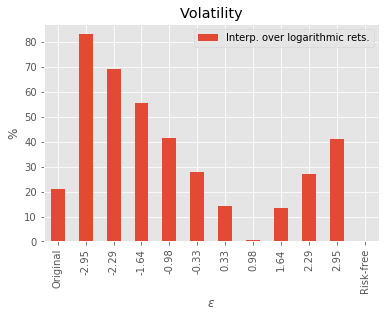

In [56]:
ax = volatility_df.mul(100).plot.bar()
ax.set(ylabel='%', xlabel='$\\varepsilon$', title='Volatility')

# plt.savefig('./figures/volatilities.png', transparent = True, bbox_inches = 'tight', dpi = 500)

---

Text(0, 0.5, '100-base prices')

Text(0.5, 1.0, 'Well-behaved annualization process')

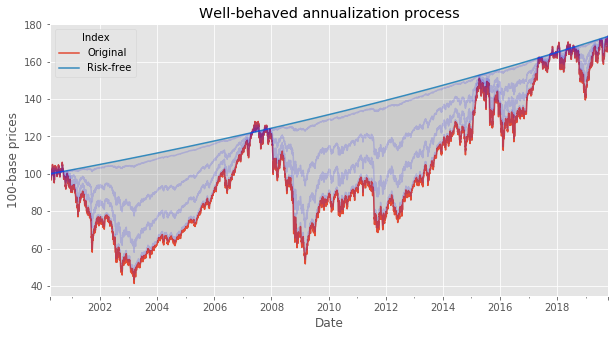

In [373]:
ax = prices_df.plot(figsize = (10,5))

space_curves_log_df.drop(columns = ['Original', 'Risk-free']).plot(ax=ax, color = 'blue', alpha = 0.15, legend=False)

ax.set_ylabel('100-base prices')
ax.set_title('Well-behaved annualization process')
ax.fill_between(prices_df.index, prices_df['Original'], prices_df['Risk-free'], 
                alpha = 0.25, color = 'grey')

plt.savefig('./figures/well_behaved_annualization_space.png', transparent = True, bbox_inches = 'tight', dpi = 500)